# Demonstrating the Utils With the ENGIE Open Data

ENGIE provides access to the data of its "La Haute Borne" wind farm through https://opendata-renewables.engie.com and through an API. The data can be used to create additional turbine objects and gives users the opportunity to work with further real-world data. 

The series of notebooks in the "examples" folder uses SCADA data downloaded from https://opendata-renewables.engie.com, saved in the "examples/data" folder. Additional plant level meter, availability, and curtailment data were synthesized based on the SCADA data.

In the following example, data is loaded into a turbine object and plotted as a power curve. The selected turbine can be changed if desired.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bokeh.plotting import show
from bokeh.io import output_notebook
output_notebook()

from openoa.utils import filters, power_curve, plot

import project_ENGIE

Loading BokehJS ...

## Import the data

In [2]:
project = project_ENGIE.prepare("./data/la_haute_borne", return_value="plantdata")

Now the data is imported we can take a look at the wind farm. There are 4 turbines, nearby foresty, a small town and neighbouring wind farms, which could impact on performance. Now lets have a look at the turbines.

**NOTE**: Here we've dropped the geometry column because the `Point` objects can't be serialized with JSON and therefore are incompatible with bokeh's plotting routines. This doesn't delete the column entirely, just for the data passed into the below plotting routine, as can be seen below in the display of the asset table.

In [3]:
show(plot.plot_windfarm(project.asset, tile_name="OpenMap", plot_width=600, plot_height=600))

In [4]:
project.asset

,latitude,longitude,elevation,rated_power,hub_height,rotor_diameter,Manufacturer,Model,type,geometry,x,y,coordinates
asset_id,,,,,,,,,,,,,
R80711,48.4569,5.5847,411.0,2050.0,80.0,82.0,Senvion,MM82,turbine,POINT (691090.6427551308 5370311.819848928),621685.960233,6.183206e+06,"(48.4569, 5.5847)"
R80721,48.4497,5.5869,411.0,2050.0,80.0,82.0,Senvion,MM82,turbine,POINT (691280.3372171954 5369517.101146103),621930.863113,6.181998e+06,"(48.4497, 5.5869)"
R80736,48.4461,5.5925,411.0,2050.0,80.0,82.0,Senvion,MM82,turbine,POINT (691707.9356258928 5369131.0084035685),622554.252261,6.181393e+06,"(48.4461, 5.5925)"
R80790,48.4536,5.5875,411.0,2050.0,80.0,82.0,Senvion,MM82,turbine,POINT (691310.0390609575 5369952.051504722),621997.654807,6.182652e+06,"(48.4536, 5.5875)"


In [5]:
# List of turbines
turb_list = project.turbine_ids
turb_list

array(['R80711', 'R80721', 'R80736', 'R80790'], dtype=object)

Let"s examine the first turbine from the list above.

In [6]:
turbine_df = project.scada.loc[project.scada.index.get_level_values("asset_id") == turb_list[0]]

ix_nan = turbine_df.WMET_HorWdSpd.isna() | turbine_df.WTUR_W.isna()
windspeed = turbine_df.loc[~ix_nan, "WMET_HorWdSpd"].copy()
power_kw = turbine_df.loc[~ix_nan, "WTUR_W"].copy()

First, we"ll make a scatter plot the raw power curve data. Notice that `example_flag` is a truth array where all values are `True`, so all of the data points are orange. However, in later plots, more meaningful filters will be explored.

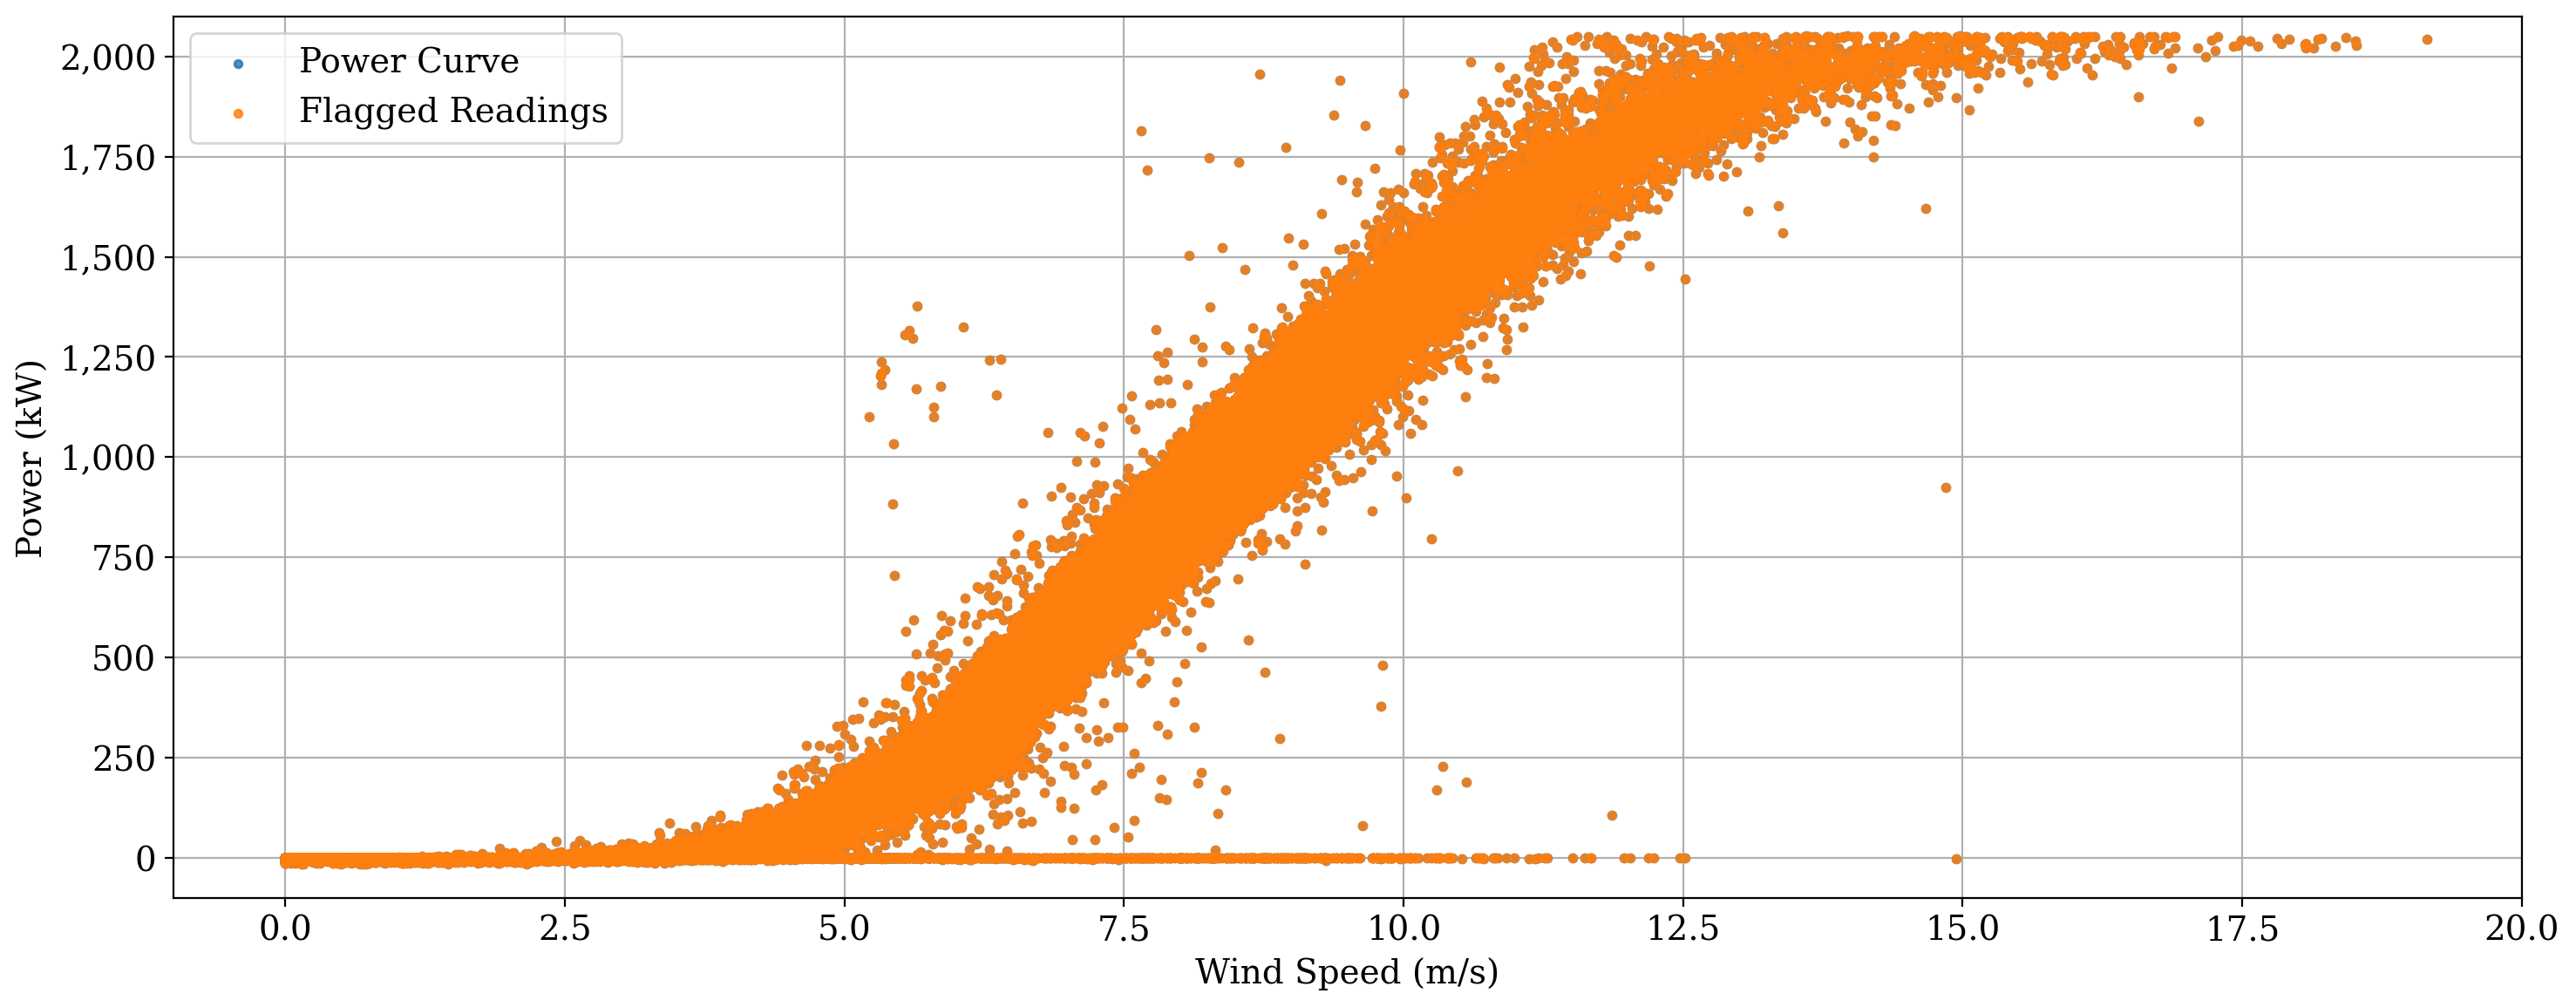

In [7]:
example_flag = np.ones(windspeed.shape, dtype=bool)
plot.plot_power_curve(
    windspeed,
    power_kw,
    flag=example_flag,
    xlim=(-1, 20),  # optional input for refining plots
    ylim=(-100, 2100),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.8, s=10)  # optional input for refining plots
)

## Range filter

Notice that none of the wind speeds are out of the acceptable range, so no plotting will be produced for this demonstration.

In [8]:
out_of_range = filters.range_flag(windspeed, lower=0, upper=70)
windspeed[out_of_range].head()

Series([], Name: WMET_HorWdSpd, dtype: float64)

## Window range filter

Now, we"ll apply a window range filter to remove data with power values outside of the window from 20 to 2100 kW for wind speeds between 5 and 40 m/s. Notice the band of orange points along the 0 kW line starting at 5 m/s representing these values.

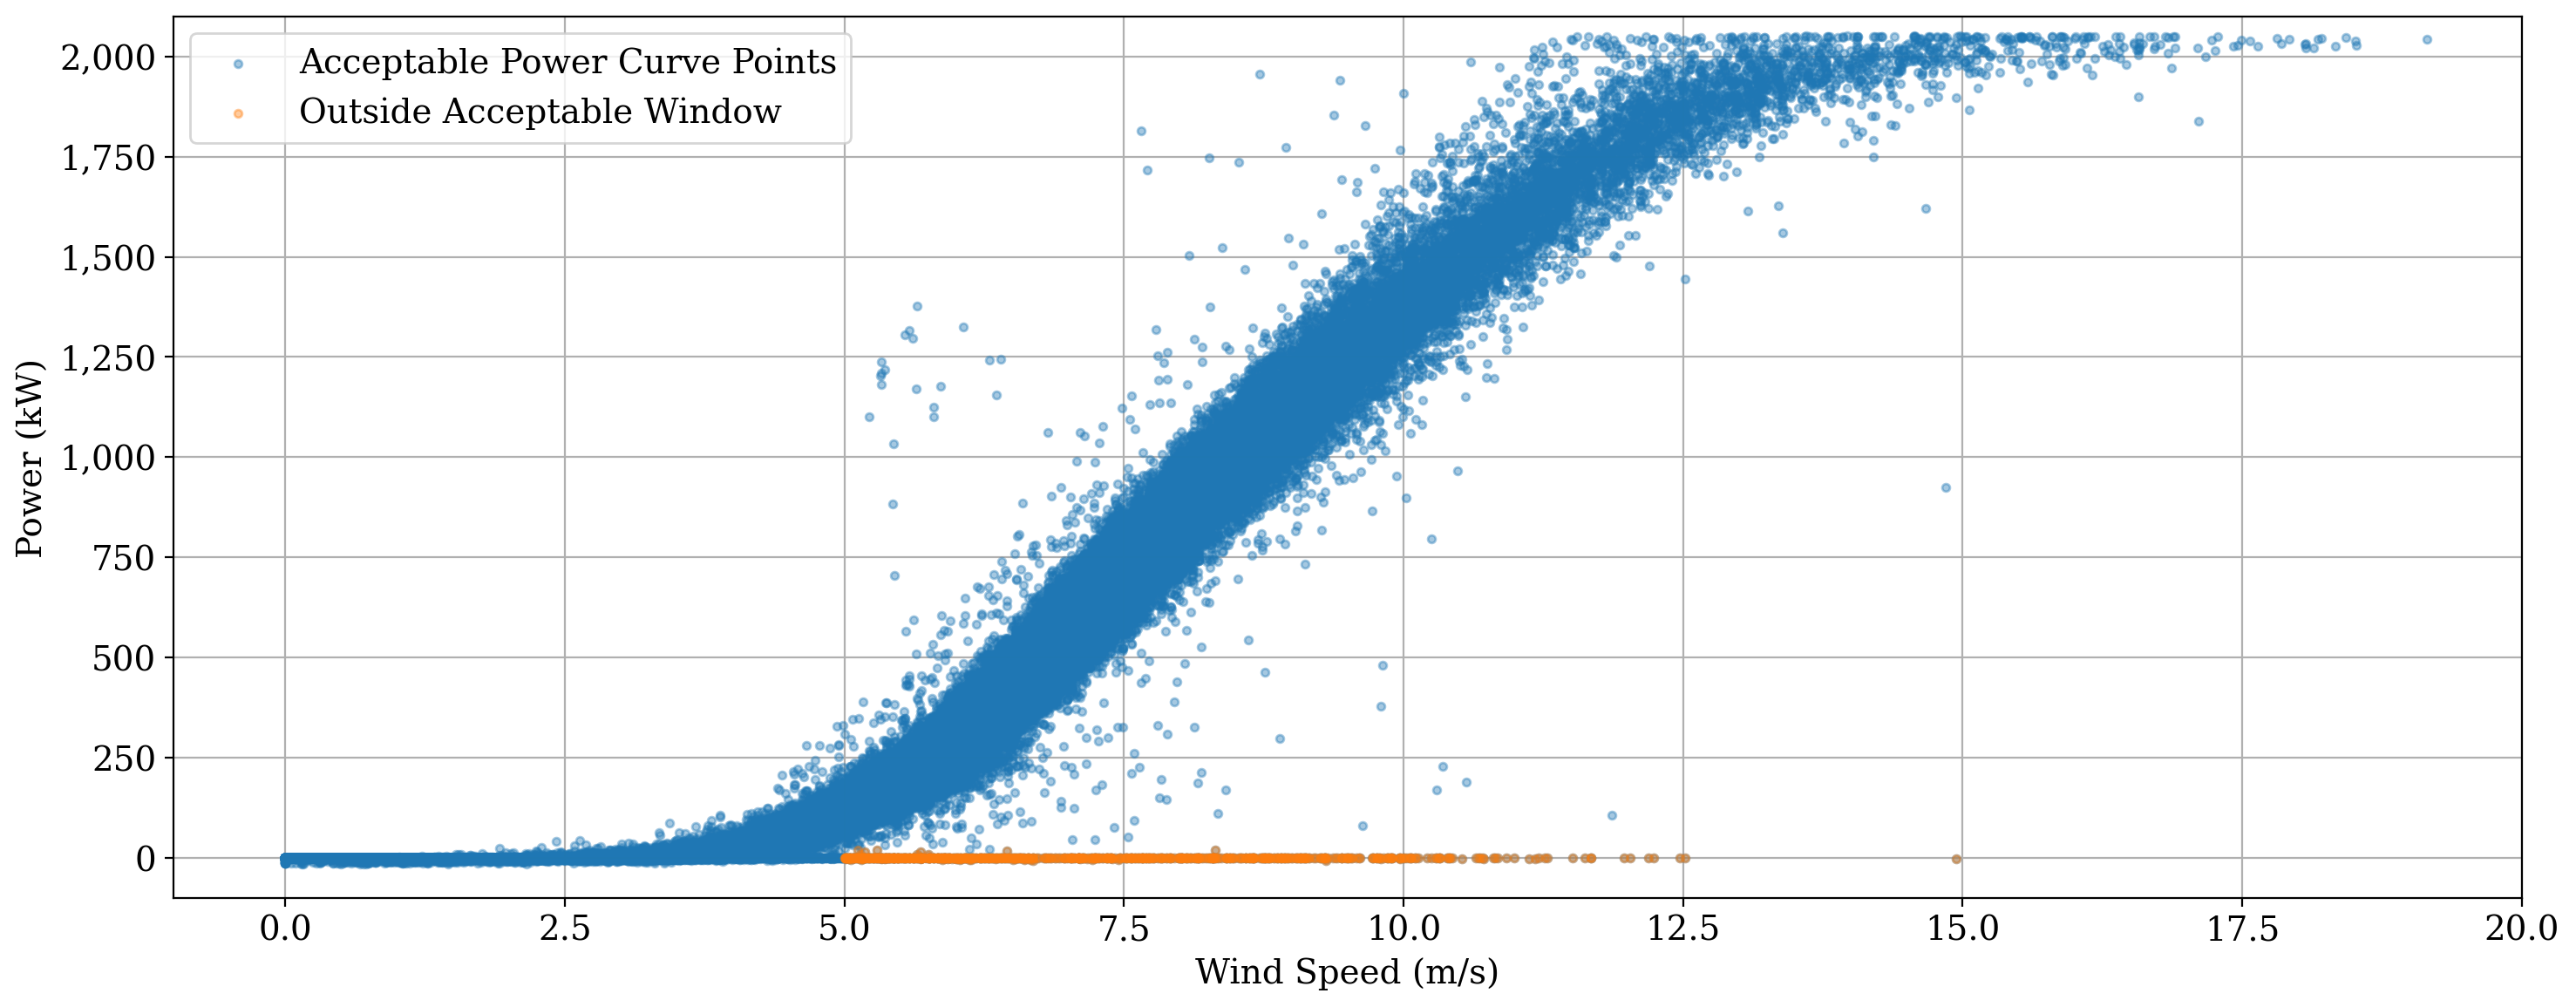

In [9]:
out_of_window = filters.window_range_flag(windspeed, 5., 40, power_kw, 20., 2100.)
plot.plot_power_curve(
    windspeed,
    power_kw,
    flag=out_of_window,
    flag_labels=("Outside Acceptable Window", "Acceptable Power Curve Points"),
    xlim=(-1, 20),  # optional input for refining plots
    ylim=(-100, 2100),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
)

Let"s remove these flagged data from consideration.

In [10]:
windspeed_filt1 = windspeed[~out_of_window]
power_kw_filt1 = power_kw[~out_of_window]

## Bin filter

We may be interested in fitting a power curve to data representing "normal" turbine operation. In other words, we want to flag all anomalous data or data represenatative of underperformance. To do this, the "bin_filter" function is useful. It works by binning the data by a specified variable, bin width, and start and end points. The criteria for flagging is based on some measure (scalar or standard deviation) from the mean or median of the bin center. 

As an example, let"s bin on power in 100 kW increments, starting from 25.0 kW but stopping at 90% of peak power (i.e. we don"t want to flag all the data at peak power and high wind speed. Let"s use a scalar threshold of 1.5 m/s from the median for each bin. Let"s also consider data on both sides of the curve by setting the "direction" parameter to "all"

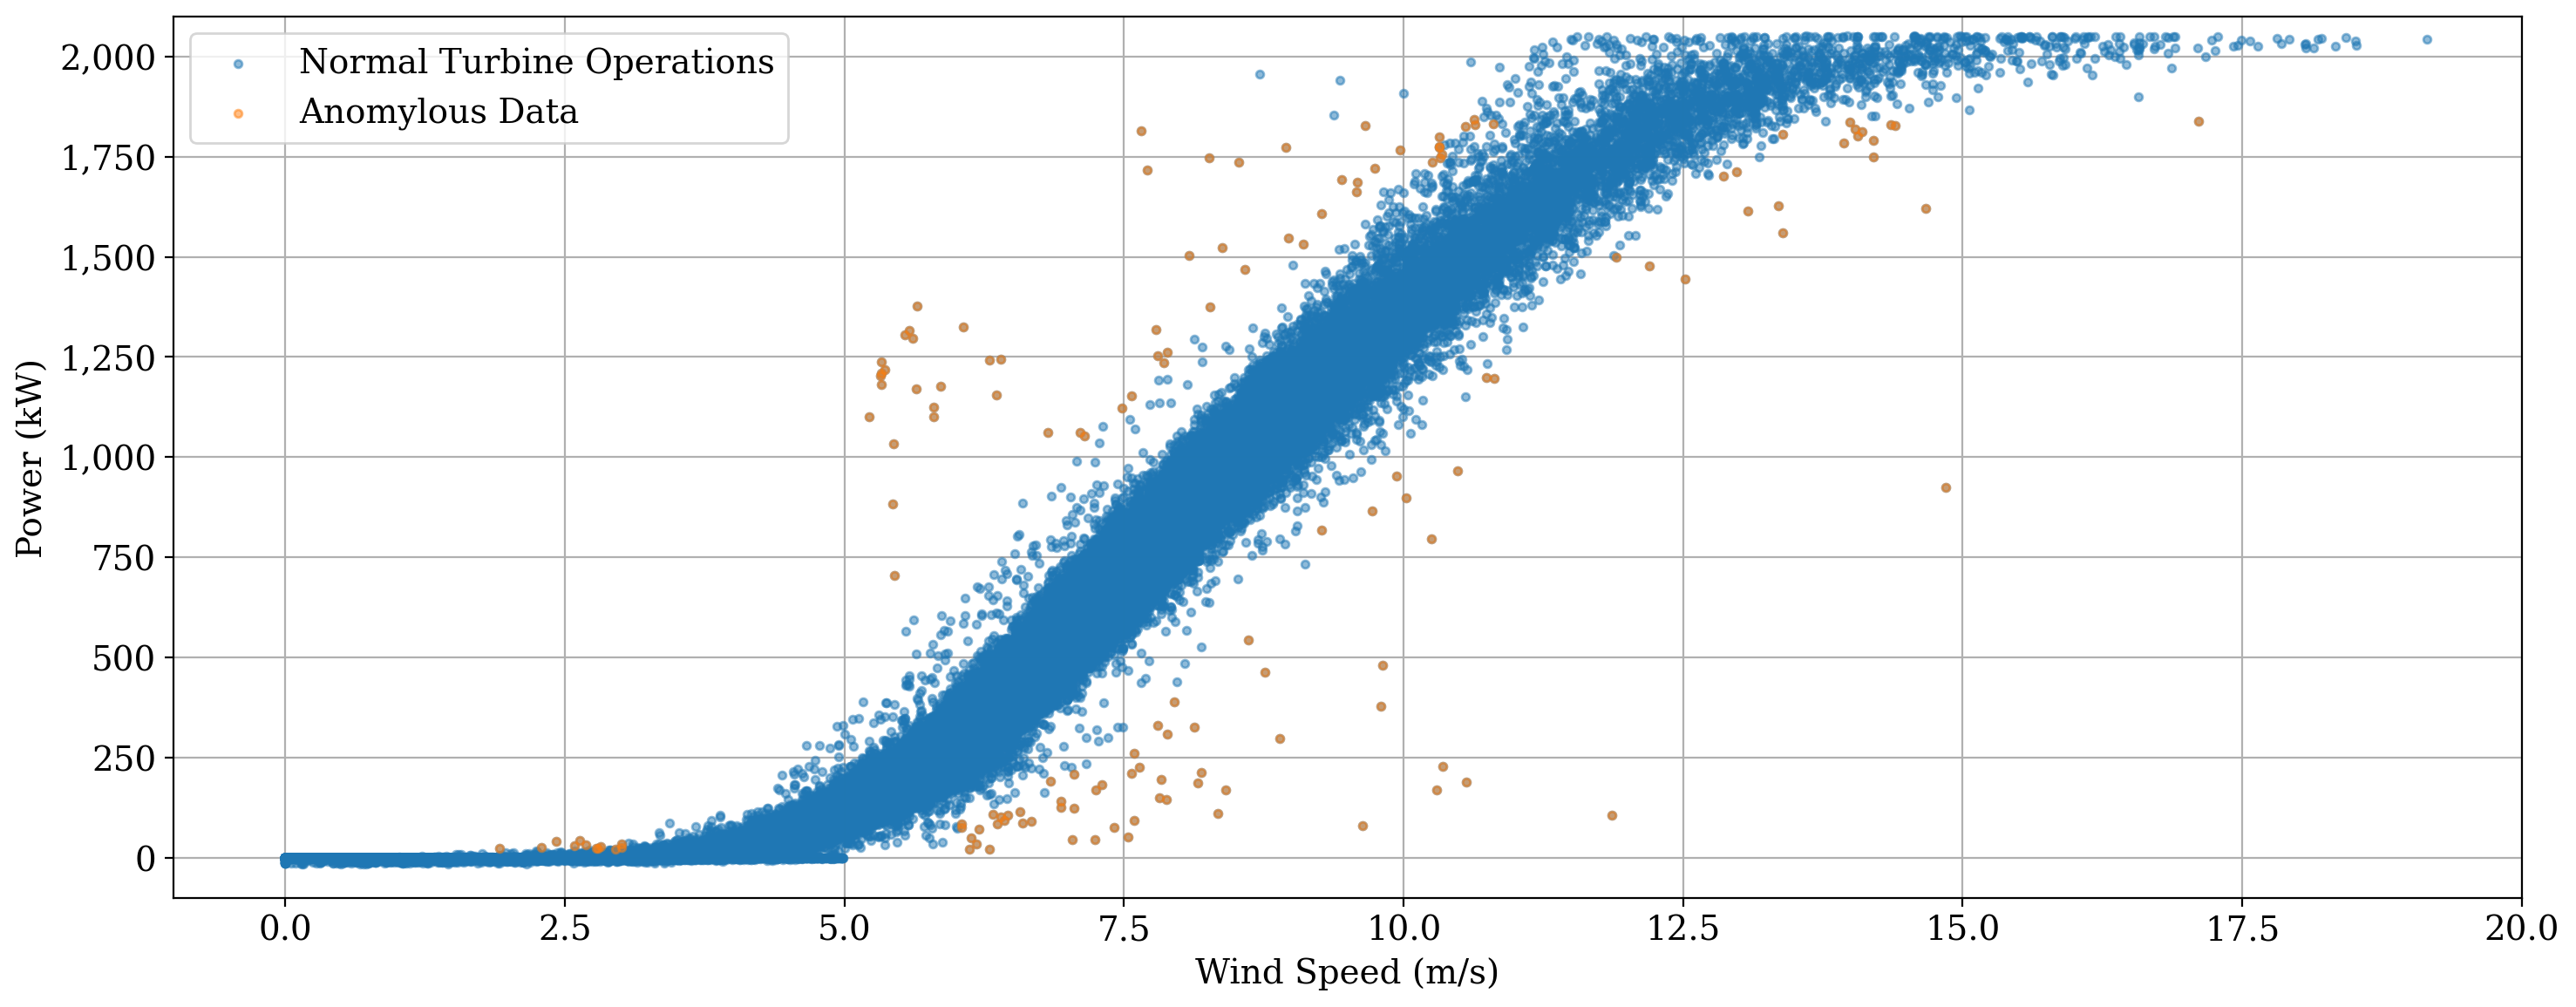

In [11]:
max_bin = 0.90 * power_kw_filt1.max()
bin_outliers = filters.bin_filter(power_kw_filt1, windspeed_filt1, 100, 1.5, "median", 20., max_bin, "scalar", "all")
plot.plot_power_curve(
    windspeed_filt1,
    power_kw_filt1,
    flag=bin_outliers,
    flag_labels=("Anomylous Data", "Normal Turbine Operations"),
    xlim=(-1, 20),  # optional input for refining plots
    ylim=(-100, 2100),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.5, s=10)  # optional input for refining plots
)

As seen above, one call for the bin filter has done a decent job of cleaning up the power curve to represent "normal" operation, without excessive removal of data points. There are a few points at peak power but low wind speed that weren"t flagged, however. Let catch those, and then remove those as well as the flagged data above, and plot our "clean" power curve 

In [12]:
windspeed_filt2 = windspeed_filt1[~bin_outliers]
power_kw_filt2 = power_kw_filt1[~bin_outliers]

## Unresponsive Filter

As a final filtering demonstration, we can look for an unrespsonsive sensor (i.e. repeating measurements). In this case, let"s look for 3 or more repeating wind speed measurements:

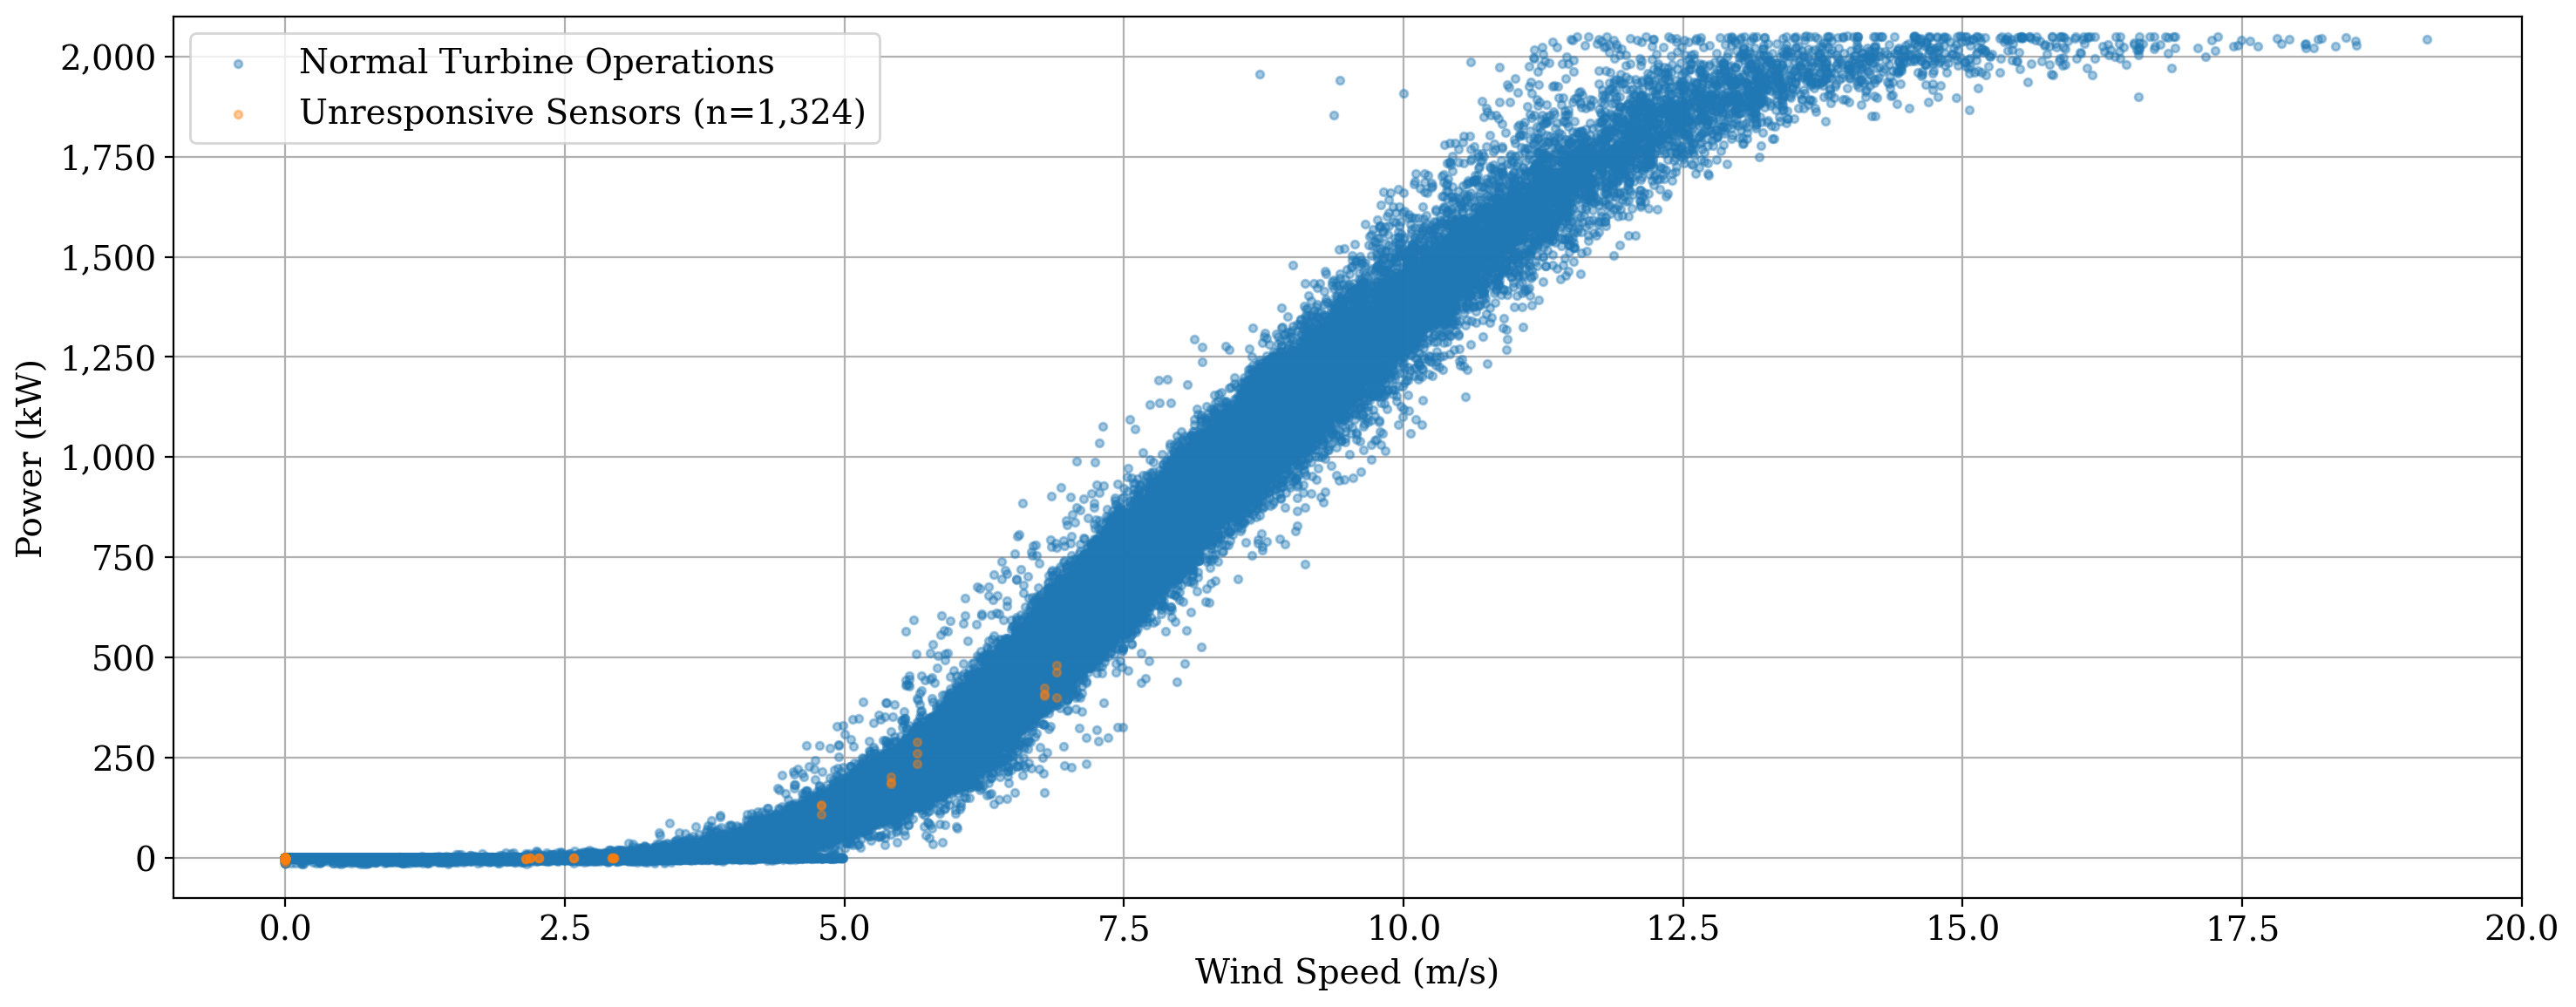

In [13]:
frozen = filters.unresponsive_flag(windspeed_filt2, 3)
plot.plot_power_curve(
    windspeed_filt2,
    power_kw_filt2,
    flag=frozen,
    flag_labels=(f"Unresponsive Sensors (n={frozen.sum():,.0f})", "Normal Turbine Operations"),
    xlim=(-1, 20),  # optional input for refining plots
    ylim=(-100, 2100),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
)

We actually found a lot, so let"s remove these data as well before moving on to power curve fitting.

Note that many of the unresponsive sensor values identified above are likely caused by the discretization of the data to only two decimal places. However, the goal is to illustrate the filtering process.

In [14]:
windspeed_final = windspeed_filt2[~frozen]
power_kw_final = power_kw_filt2[~frozen]

## Power curve fitting

We will now consider three different models for fitting a power curve to the SCADA data.

In [15]:
# Fit the power curves
iec_curve = power_curve.IEC(windspeed_final, power_kw_final)
l5p_curve = power_curve.logistic_5_parametric(windspeed_final, power_kw_final)
spline_curve = power_curve.gam(windspeed_final, power_kw_final, n_splines=20)

  return d + (a - d) / (1 + (x / c) ** b) ** g



First, we"ll generate the base plot, and with the returned figure and axes objects, we"ll overlay the fitted power curves to highlight their fit.

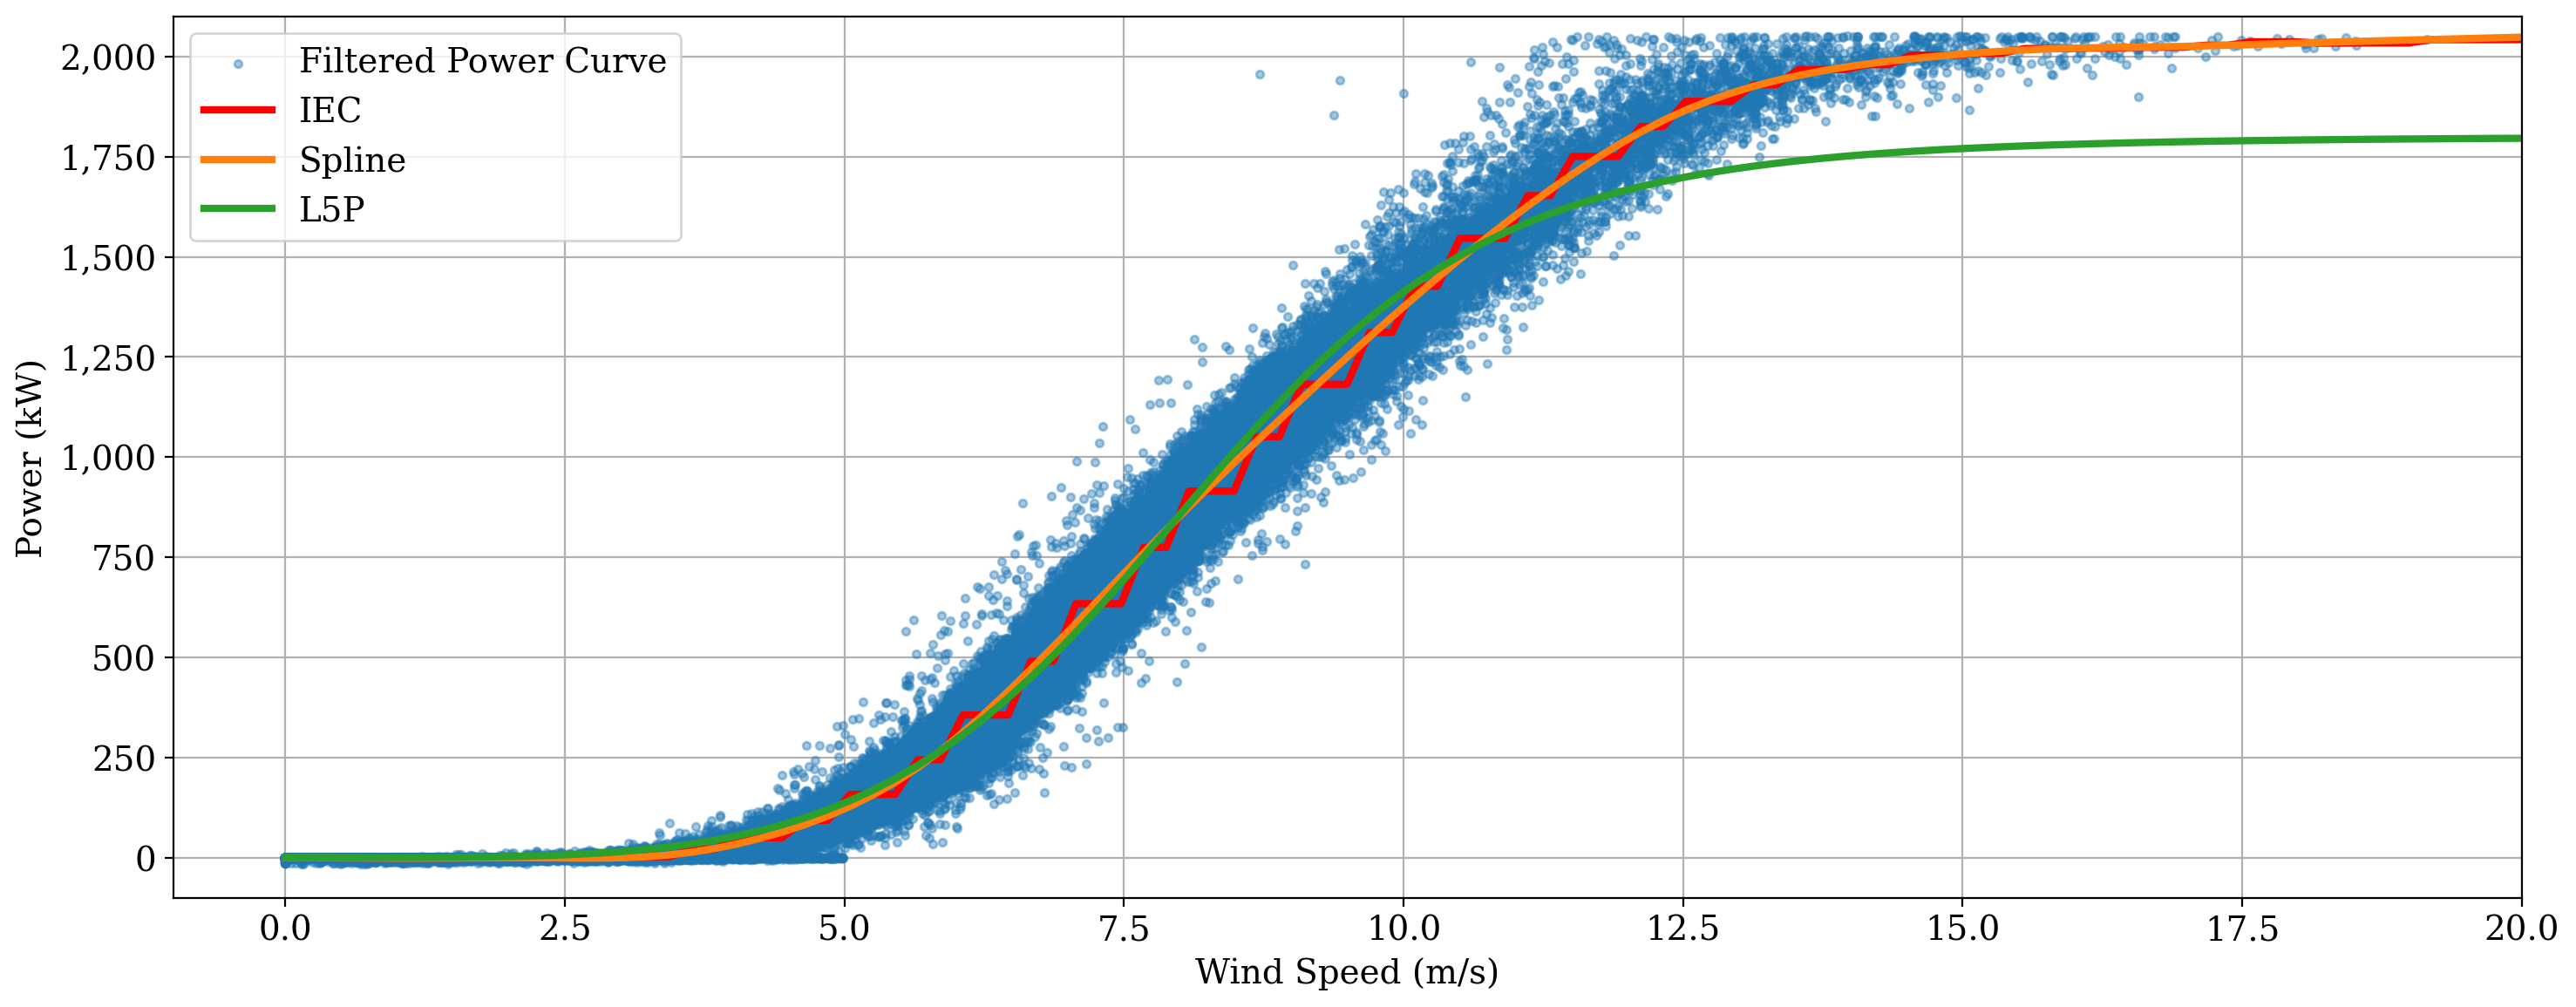

In [16]:
fig, ax = plot.plot_power_curve(
    windspeed_final,
    power_kw_final,
    flag=np.zeros(windspeed_final.shape, dtype=bool),
    flag_labels=("", "Filtered Power Curve"),
    xlim=(-1, 20),  # optional input for refining plots
    ylim=(-100, 2100),  # optional input for refining plots
    legend=False,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10),  # optional input for refining plots
    return_fig=True,
)

x = np.linspace(0, 20, 100)
ax.plot(x, iec_curve(x), color="red", label = "IEC", linewidth = 3)
ax.plot(x, spline_curve(x), color="C1", label = "Spline", linewidth = 3)
ax.plot(x, l5p_curve(x), color="C2", label = "L5P", linewidth = 3)

ax.legend()

fig.tight_layout()
plt.show()

The above plot shows that the IEC method accurately captures the power curve, although it results in a "choppy" fit, while the L5P model (constrained by its parametric form) deviates from the knee of the power curve through peak production. The spline fit tends to fit the best.